**Задание номер 1 лаборатории «Техническое зрение».  Конкурс-хакатон «Техническое зрение».**

*Создать программу, которая анализирует аэрофотоснимки и определяет оптимальные маршруты для полета дронов, учитывая различные препятствия, такие как здания, деревья и другие объекты.*

Ющев Роман


**Task 1 of the "Technical Vision" laboratory. The "Technical Vision" hackathon contest.**

Create a program that analyses aerial photographs and identifies the optimal routes for a drone flight, considering various obstacles such as buildings, trees, and other objects.

Yushchev Roman

# 1 Setup

In [1]:
# @title 1.1 Check CUDA
!nvidia-smi


Tue May 14 08:58:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%%capture
#@title 1.2 Installing dependencies

!pip install networkx[default]

import numpy as np

import networkx as nx

from torchvision import transforms
import torch
import torch.nn as nn

from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

import cv2
from PIL import Image, ImageChops, ImageDraw

from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt


In [3]:
%%capture
#@title 1.3 Installing SegFormer weights and test images
!gdown 1ilnlleyU63LKukUAiXcuyA3lvaOZ6CoL # weights of SegFormer
!gdown 1H-ITVh6e5LYMGosu6JGIpb-CoqQ9UWuv # images
!unzip Images.zip

# 2 Models

In [4]:
%%capture
#@title 2.1 SegFormer
weights_path = '/content/last_model.pt'

id2label = {0: 'Building',
            1: 'Land',
            2: 'Road',
            3: 'Vegetation'
            }
label2id = {v: k for k, v in id2label.items()}

image_processor = SegformerImageProcessor(reduce_labels=True)
# define model
SegmentationModel = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b4",
                                                         num_labels=4,
                                                         id2label=id2label,
                                                         label2id=label2id,
)
SegmentationModel.load_state_dict(torch.load(weights_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SegmentationModel.to(device);

In [5]:
%%capture
#@title 2.3 Depth Anything

#@markdown Select the type of model you want.
#@markdown - depth-anything-small: include 24.8M params
#@markdown - depth-anything-base: include 97.5M params
#@markdown - depth-anything-large: include 335.3M params
depth_anything_type = "large" #@param ["small", "base", "large"]

depth_anything_image_processor = AutoImageProcessor.from_pretrained(f"LiheYoung/depth-anything-{depth_anything_type}-hf")
depth_anything = AutoModelForDepthEstimation.from_pretrained(f"LiheYoung/depth-anything-{depth_anything_type}-hf")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
depth_anything.to(device);

# 3 Functions and algorithms for building a route

In [6]:
#@title 3.1 Computing the segmentation map
def ComputeSegMap_SegFormer(image):
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = SegmentationModel(pixel_values=pixel_values)
        predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

    predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

    color_seg = np.zeros((predicted_segmentation_map.shape[0], predicted_segmentation_map.shape[1])).astype('uint8')

    color_seg[predicted_segmentation_map == 0] = 20 # building
    color_seg[predicted_segmentation_map == 1] = 200 # land
    color_seg[predicted_segmentation_map == 2] = 230 # Road
    color_seg[predicted_segmentation_map == 3] = 75 # Vegetation

    return Image.fromarray(color_seg)

In [7]:
#@title 3.2 Computing the depth map

def ComputeDepthmap(image):
    transformed_image = depth_anything_image_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = depth_anything(**transformed_image)
        predicted_depth = outputs.predicted_depth

    predicted_depth = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # visualize the prediction
    output = predicted_depth.squeeze().cpu().numpy()
    output = (output * 255 / np.max(output)).astype("uint8")
    output = ImageChops.invert(Image.fromarray(output))
    return output

In [8]:
#@title 3.3 Computing the flight probability map
#@markdown Computed based on the depth map and the segmentation map. The probability of flying over a pixel is calculated as the ratio of the pixel value (uint8) and 255


def ComputeProbMap(seg_map, dep_map):
    # Clarifying the boundaries of objects on the segmentation map and overlapping random outliers
    seg = np.asarray(seg_map)
    seg = cv2.GaussianBlur(seg, (9, 9), 0)

    edge = cv2.Canny(seg, 10, 180, L2gradient = True)
    contours, _ = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    smoothed_contours = [cv2.approxPolyDP(cnt, 0.1 * cv2.arcLength(cnt, True), True) for cnt in contours]

    for contour in smoothed_contours:
        mask = np.zeros(seg.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [contour], -1, 255, -1)

        masked = cv2.bitwise_and(seg, seg, mask=mask)
        masked = masked[mask != 0]
        values, counts = np.unique(masked, return_counts=True)
        dominant_color = values[counts.argmax()]

        cv2.drawContours(seg, [contour], -1, dominant_color.tolist(), cv2.FILLED)

    dep = np.asarray(dep_map)
    # The probability map will be inverted later, therefore, in a place with a minimum probability of flight, the pixel value is 255
    prob = np.multiply(dep/np.max(dep), seg)
    prob_map = np.full((prob.shape[0], prob.shape[1]), 255).astype('uint8')

    prob_map[prob < np.max(prob)*0.8] = 230
    prob_map[prob < np.max(prob)*0.7] = 200
    prob_map[prob < np.max(prob)*0.6] = 180
    prob_map[prob < np.max(prob)*0.5] = 150
    prob_map[prob < np.max(prob)*0.4] = 127
    prob_map[prob < np.max(prob)*0.3] = 100
    prob_map[prob < np.max(prob)*0.2] = 76
    prob_map[prob < np.max(prob)*0.1] = 30

    return Image.fromarray(prob_map.astype('uint8'))

In [9]:
#@title 3.4 Computing a graph based on an image
#@markdown In the graph, points that are 9 pixels apart are selected according to a given grid. These points become nodes in the graph. The weight of a branch is calculated as the average value of the pixels in a 9x9 square that is plotted between the two points. An example of this is shown in the image below.

def Compute_grapf(prob_map):
    prob_map = ImageChops.invert(prob_map)
    img = np.asarray(prob_map)
    graph_side = 9
    alpha = graph_side // 2
    beta = graph_side

    G = nx.Graph()

    for y in range(graph_side // 2, graph_side*(img.shape[0]//graph_side - 1), graph_side):
        for x in range(graph_side // 2, graph_side*(img.shape[1]//graph_side - 1), graph_side):

            main_node = f'{x},{y}'

            righ_node = f'{x+graph_side},{y}'
            down_node = f'{x},{y+graph_side}'
            diag_node = f'{x+graph_side},{y+graph_side}'

            right = img[(y-alpha):(y+alpha+1), (x+1):(x+beta+1)]
            down = img[(y+1):(y+beta+1), (x-alpha):(x+alpha+1)]
            diag = img[(y+1):(y+beta+1), (x+1):(x+beta+1)]

            if x > graph_side:
                diag2_node = f'{x-graph_side},{y+1}'
                diag2 = img[(y+1):(y+beta+1), (x-beta):(x)]
                G.add_edge(main_node, diag2_node, weight = int(np.average(diag2)))

            G.add_edge(main_node, righ_node, weight = int(np.average(right)))
            G.add_edge(main_node, down_node, weight = int(np.average(down)))
            G.add_edge(main_node, diag_node, weight = int(np.average(diag)))

    return G

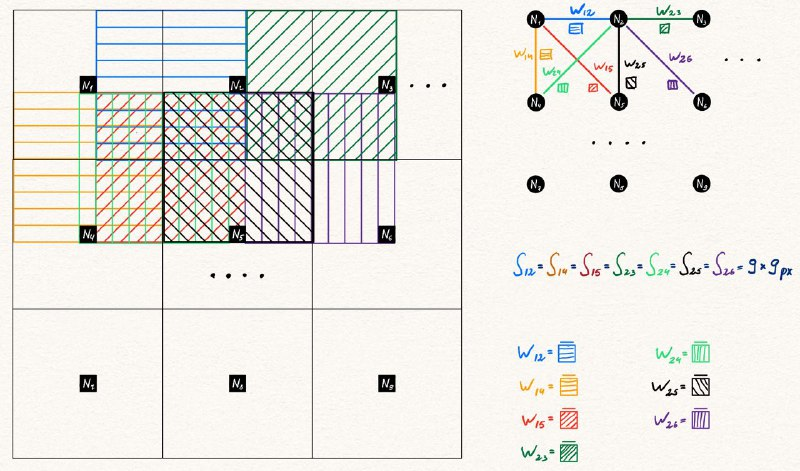

In [10]:
#@title 3.5 Computing the optimal path

def smooth_path(path):
    x_arr = []
    y_arr = []
    res = []

    # Division into X and Y coordinates
    for item in path:
        x, y = item.split(',')
        x_arr.append(int(x))
        y_arr.append(int(y))

    x = np.array(x_arr)
    y = np.array(y_arr)

    num_of_points = int(x.size/4)
    # The representation of a path of flight (a function defined as y(x)) in terms of parametric equations x(t) and y(t),
    # where t represents some increasing variable, in this case, the index in an array.
    # This is done to avoid interpolation errors caused by duplicated x-values.
    t = np.arange(0, int(x.size))

    xt = make_interp_spline(t, x)
    yt = make_interp_spline(t, y)

    tn = np.linspace(t.min(),t.max(),num_of_points).astype(int)

    x_n = xt(tn).astype(int)
    y_n = yt(tn).astype(int)

    for i in range(num_of_points):
        res.append(f'{x_n[i]},{y_n[i]}')
    return res

def Compute_path_betwen_2_points(grapf, first_point, second_point):
    # Find the nearest points to the specified ones, which are graph nodes, and reinitialize the points.
    repoint = tuple(map(int, first_point.split(',')))
    repoint_f = (repoint[0]//9)*9+4
    repoint_s = (repoint[1]//9)*9+4
    first_point = f'{repoint_f},{repoint_s}'

    repoint = tuple(map(int, second_point.split(',')))
    repoint_f = (repoint[0]//9)*9+4
    repoint_s = (repoint[1]//9)*9+4
    second_point = f'{repoint_f},{repoint_s}'
    # Finding the shortest path and its length
    path = nx.shortest_path(grapf, first_point, second_point, weight='weight')
    length = nx.shortest_path_length(grapf, first_point, second_point, weight='weight')
    return smooth_path(path), length

def draw_path(image, path_of_flight):

    coordinates = [tuple(map(int, point.split(','))) for point in path_of_flight]
    img = np.asarray(image)
    img = np.copy(img)
    for i in range(len(path_of_flight)-1):
        cv2.line(img, coordinates[i], coordinates[i+1], (255, 0, 0), 10)
    return Image.fromarray(img)

# 4 Run

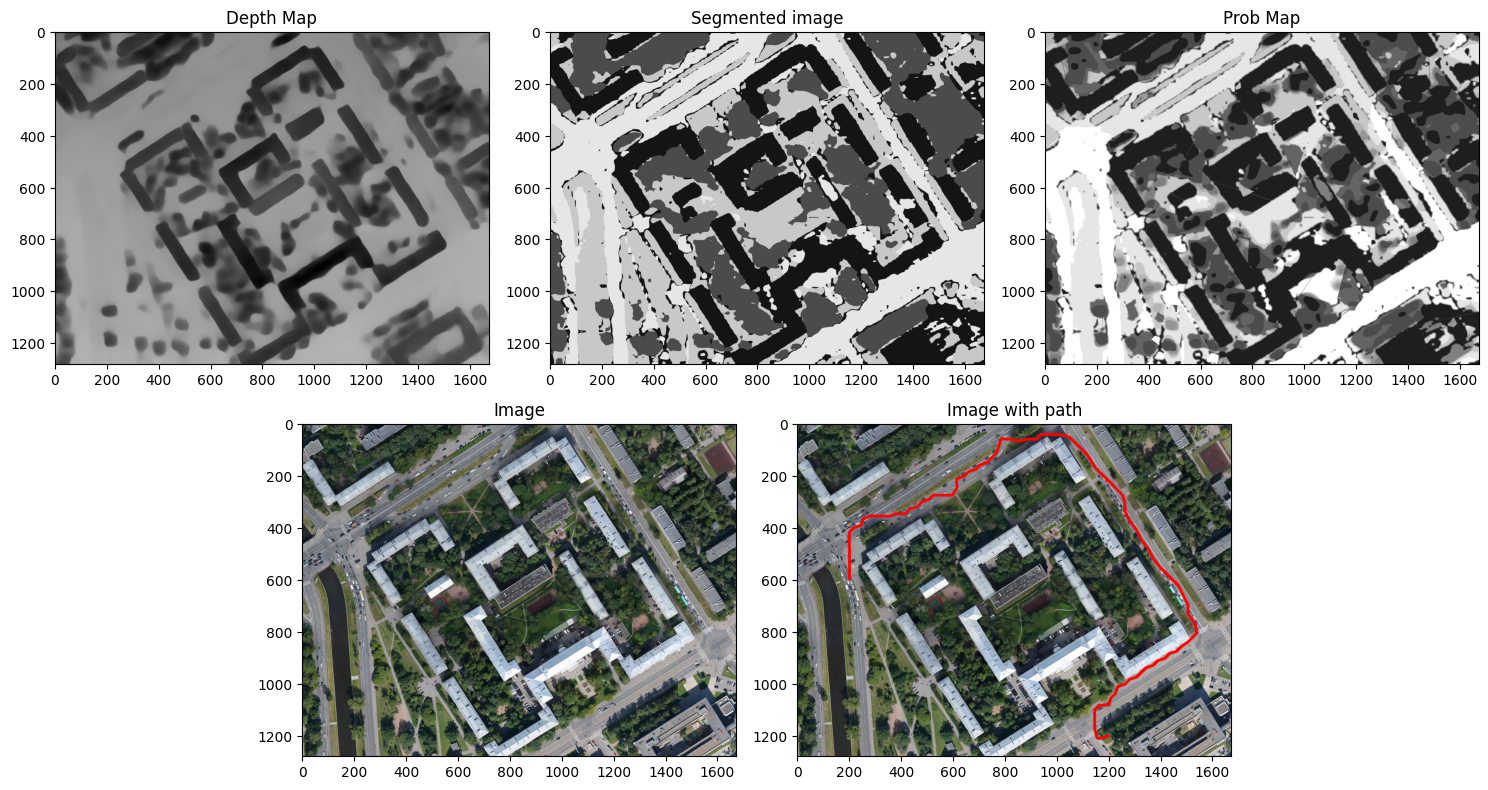

In [ ]:
image = Image.open('/content/Images/8.png').convert('RGB')
SM = ComputeSegMap_SegFormer(image)
DM = ComputeDepthmap(image)
PM = ComputeProbMap(SM, DM)
Grapf = Compute_grapf(PM)
path_of_flight, length_of_flight = Compute_path_betwen_2_points(Grapf, '200,600', '1200,1200')
pathed_im = draw_path(image, path_of_flight)

fig = plt.figure(figsize = (15,8))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

ax1.set_title("Depth Map")
ax1.imshow(DM.convert('RGB'))

ax2.set_title("Segmented image")
ax2.imshow(SM.convert('RGB'))

ax3.set_title("Prob Map")
ax3.imshow(PM.convert('RGB'))

ax4.set_title("Image")
ax4.imshow(image)

ax5.set_title("Image with path")
ax5.imshow(pathed_im)

fig.tight_layout()